Tutorial 4: Dealing With Failure
================================

In the last tutorial we showed how our `NonLinearSearch` can potentially fail, and infer a local maxima solution.
In this tutorial, we're going to learn how to stop this and infer the globally maximal lens model.

In the previous tutorial, when we inferred a local maxima we knew that we had done so. For modeling a real lens,
we do not know the *true* lens model and it is often  unclear if a solution is a global or local maximma. The tricks
we learn in this tutorial are therefore equally important for verifying that a solution does indeed appear to be the
global maxima.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import numpy as np
from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's `LightProfile` is an `EllipticalSersic`.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalExponential`.

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

we'll create and use a smaller 2.0" `Mask2D` again.

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=2.6
)

When plotted, the lens light`s is clearly visible in the centre of the image.

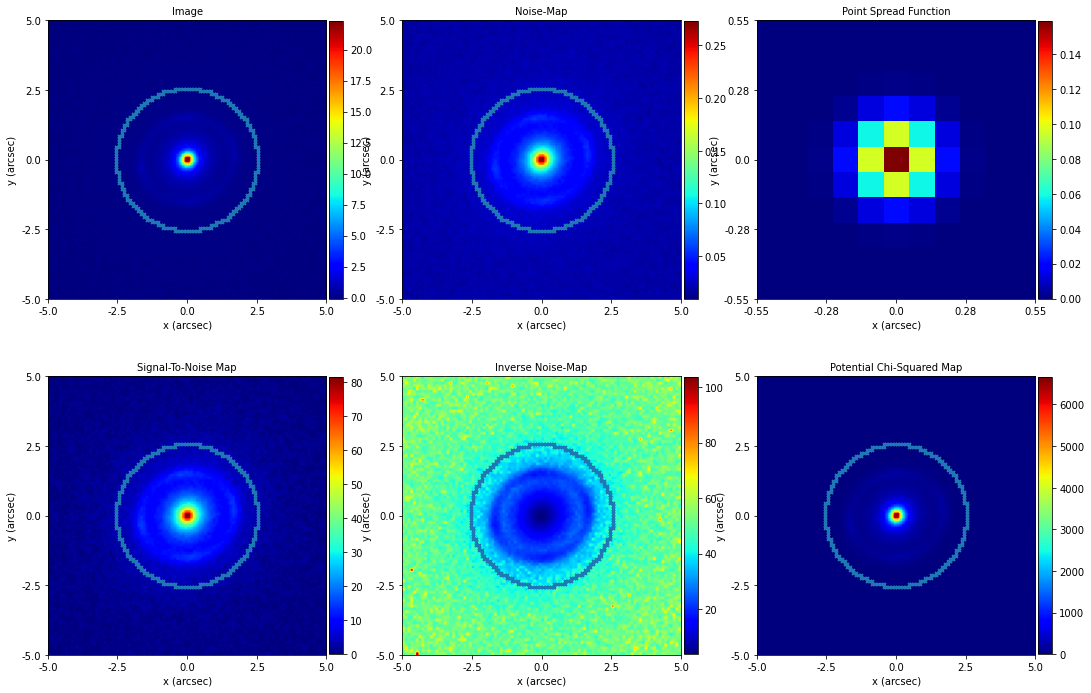

In [4]:
imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

Like in the previous tutorials, we use a `SettingsPhaseImaging` object to specify our model-fitting procedure uses a 
regular `Grid2D`.

In [5]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

__Approach 1: Prior Tuning__

First, we're going to try giving our `NonLinearSearch` a helping hand. Lets think about our priors, they`re telling 
the `NonLinearSearch` where to look in parameter space. If we tell it to look in the right place (that is, 
*tune* our priors), it might find the best-fit lens model.

We've already seen that we can fully customize priors in **PyAutoLens**, so lets do it. I've set up a custom phase 
below and specified a new set of priors that'll give the `NonLinearSearch` a much better chance if inferring the 
correct model. I've also let you know what we're changing the priors from (as initially specified by the 
`config/priors/default` config files.)

we'll call our lens and source galaxies `lens` and `source` this time, for shorter more readable code.

In a later tutorial, we'll cover `NonLinearSearch` approaches that are different to Dynesty, where one provides the
non-linear search with a *starting point* where it samples parameter space. In a similar fashion to prior tuning,
giving these searches a good starting point will increase the chances of us finding the global maxima.

In [6]:
lens = al.GalaxyModel(
    redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
)

By default, the prior on the $(y,x)$ coordinates of a `LightProfile` / `MassProfile` is a GaussianPrior with mean 0.0" and 
sigma "1.0. However, visual inspection of our strong lens image tells us that its clearly around x = 0.0" and y = 0.0", 
so lets reduce where `NonLinearSearch` looks for these parameters.

In [7]:
lens.bulge.centre.centre_0 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
lens.bulge.centre.centre_1 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
lens.mass.centre.centre_0 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
lens.mass.centre.centre_1 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)

By default, the elliptical components of the of our lens galaxy's elliptical `LightProfile` are `UniformPriors` 
between -1.0 and 1.0, corresponding to the full range of possible ellipses with axis-ratio from 0.0 to 1.0 and 
position angles from 0.0 to 180.0 degrees.

However, looking close to the image it is clear that the lens galaxy's light is elliptical and oriented around 
45.0 degrees counter-clockwise from the x-axis. We can update the priors on our elliptical components to reflect this.

In [8]:
lens.bulge.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.333333, sigma=0.1, lower_limit=-1.0, upper_limit=1.0
)
lens.bulge.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-1.0, upper_limit=1.0
)

Lets additionally assume that the `LightProfile`'s ellipticity informs us of the `MassProfile`'s ellipticity. Because 
this may not strictly be true (e.g. because of dark matter) we'll use a wider prior.

In [9]:
lens.mass.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.333333, sigma=0.3, lower_limit=-1.0, upper_limit=1.0
)
lens.mass.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.0, sigma=0.3, lower_limit=-1.0, upper_limit=1.0
)

The effective radius of a `LightProfile` is its `half-light` radius, the radius at which 50% of its total luminosity 
is internal to a circle defined within that radius. **PyAutoLens** assumes a UniformPrior on this quantity between 0.0" and 
4.0", but inspection of the image (again, using a colormap scaling) shows the lens's light doesn`t extend anywhere near 
4.0", so lets reduce it.

In [10]:
lens.bulge.effective_radius = af.GaussianPrior(
    mean=1.0, sigma=0.8, lower_limit=0.0, upper_limit=np.inf
)

Typically, we have knowledge of our lens galaxy's morphology. Most strong lenses are massive elliptical galaxies which 
have Sersic indexes near 4. So lets change our Sersic index from a UniformPrior between 0.8 and 8.0 to reflect this.

In [11]:
lens.bulge.sersic_index = af.GaussianPrior(
    mean=4.0, sigma=1.0, lower_limit=0.0, upper_limit=np.inf
)

Finally, the `ring` that the lensed source forms clearly has a radius of about 1.6". This is its Einstein radius, so 
lets change the prior from a UniformPrior between 0.0" and 4.0".

In [12]:
lens.mass.einstein_radius = af.GaussianPrior(
    mean=1.6, sigma=0.2, lower_limit=0.0, upper_limit=np.inf
)

In this exercise, I'm not going to change any priors on the source galaxy. Whilst lens modeling experts can look at a 
strong lens and often tell you roughly where the source-galaxy is located (in the source-plane), it is something of art 
form. Furthermore, the source's morphology can be pretty complex, making it difficult to come up with a good source prior!

In [13]:
source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalExponential)

We can now create this custom phase and run it. Our `NonLinearSearch` will now start by sampling higher likelihood 
regions of parameter space, given our improved and more informed priors.

In [14]:
phase = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens", name="phase_t4_custom_priors", n_live_points=50
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
)

print(
    "Dynesty has begun running - checkout the workspace/output/4_dealing_with_failure"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_custom_priors = phase.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

Dynesty has begun running - checkout the workspace/output/4_dealing_with_failure folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:phase_t4_custom_priors already completed, skipping non-linear search.


Dynesty has finished run - you may now continue the notebook.


Bam! We get a good model, which indeed corresponds to the global maxima. By giving our `NonLinearSearch` a helping hand
and informing it of where to sample parameter space, we can increase the odds that we find the global maxima solution.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


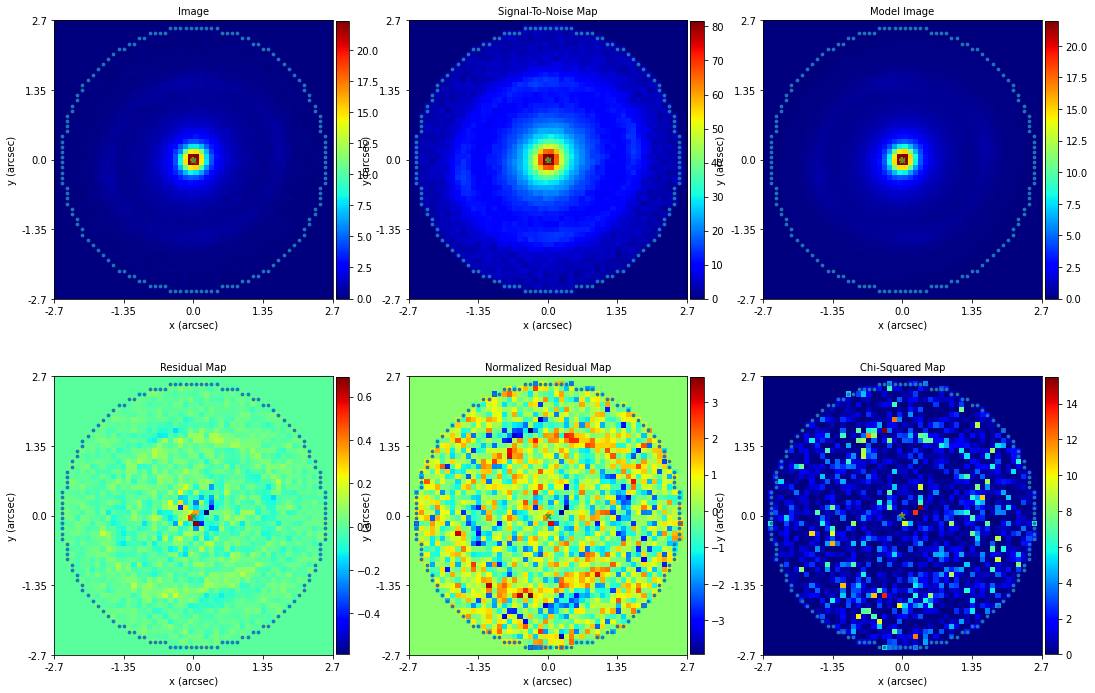

In [15]:
fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=result_custom_priors.max_log_likelihood_fit
)
fit_imaging_plotter.subplot_fit_imaging()

By tuning our priors to the lens we're fitting we can increase our chance of inferring the global maxima lens model. 
Before moving onto the next approach, lets think about the advantages and disadvantages of prior tuning:

Advantages: 

 - We find the maximum log likelihood solution in parameter space.
 - The phase took less time to run because the `NonLinearSearch` explored less of parameter space.

Disadvantages: 

 - If we specified a prior incorrectly the `NonLinearSearch` would begin and therefore end at an incorrect solution.
 - Our phase was tailored to this specific strong lens. If we want to fit a large sample of lenses we`d 
 have to write a custom phase for every single one - this would take up a lot of our time!

__Approach 2: Reducing Complexity__

Previously, Our non-linear searched failed because we made the lens model more complex. Can we can make it less complex, 
whilst still keeping it fairly realistic? Maybe there are some assumptions we can make to reduce the number of 
lens model parameters and therefore dimensionality of non-linear parameter space?

Well, we can *always* make assumptions. Below, I'm going to create a phase that assumes that light-traces-mass. That 
is, that our `LightProfile`'s centre, and elliptical components are perfectly aligned with its mass. This may, or may 
not, be a reasonable assumption, but it`ll remove 4 parameters from the lens model (the `MassProfile`'s y, x, and 
elliptical components), so its worth trying!

In [16]:
lens = al.GalaxyModel(
    redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
)

source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalExponential)

In the pass priors function we can `pair` any two parameters by setting them equal to one another. This removes the 
parameter on the left-hand side of the pairing from the lens model such that is always assumes the same value as the 
parameter on the right-hand side.

In [17]:
lens.mass.centre = lens.bulge.centre

Lets do this with the elliptical components of the light and mass profiles.

In [18]:
lens.mass.elliptical_comps = lens.bulge.elliptical_comps

Again, we create this phase and run it. The `NonLinearSearch` now has a less complex parameter space to search.

INFO:root:phase_t4_light_traces_mass already completed, skipping non-linear search.


Dynesty has begun running - checkout the workspace/output/4_dealing_with_failure folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


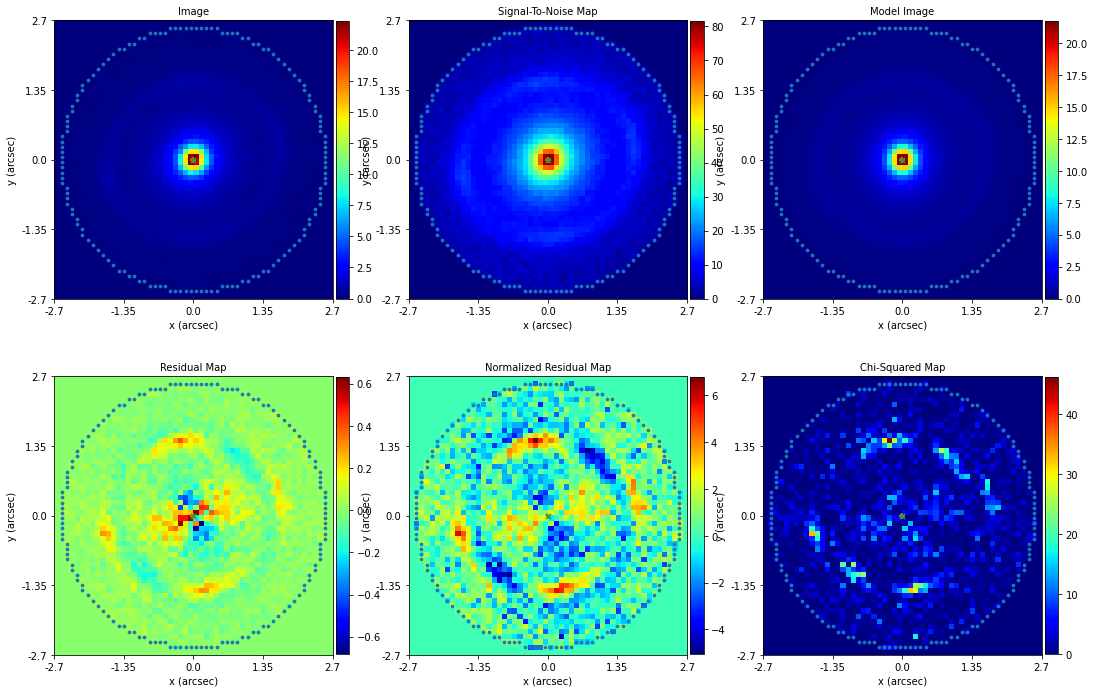

In [19]:
phase_light_traces_mass = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens", name="phase_t4_light_traces_mass", n_live_points=40
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
)

print(
    "Dynesty has begun running - checkout the workspace/output/4_dealing_with_failure"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_light_trace_mass = phase_light_traces_mass.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=result_light_trace_mass.max_log_likelihood_fit
)
fit_imaging_plotter.subplot_fit_imaging()

The results look pretty good. Our source galaxy fits the data pretty well and we've clearly inferred a model that 
looks similar to the one above. However, inspection of the residuals shows that the fit wasn`t quite as good as the 
custom-phase above.

It turns out that when I simulated this image light didn`t perfectly trace mass. The `LightProfile`'s elliptical 
components were (0.333333, 0.0) whereas the `MassProfile`'s were (0.25, 0.0). The quality of the fit has suffered as a 
result and the log likelihood we inferred is lower.

Herein lies the pitfalls of making assumptions - they may make your model less realistic and your fits worse! 

Again, lets consider the advantages and disadvantages of this approach:

Advantages:

 - By reducing parameter space`s complexity we inferred a global maximum log likelihood.
 - The phase is not specific to one lens - we could run it on many strong lens images.
    
Disadvantages:

 - Our model was less realistic and our fit suffered as a result.

__Approach 3: Look Harder__

In approaches 1 and 2 we extended our `NonLinearSearch` an olive branch and helped it find the highest log likelihood 
regions of parameter space. In approach 3 ,we're going to tell it to just `look harder`.

Basically, every `NonLinearSearch` has a set of parameters that govern how thoroughly it searches parameter 
space. The more thoroughly it looks, the more likely it is that it`ll find the global maximum lens model. However, 
the search will also take longer - and we don't want it to take too long to get us a result!

In tutorial 7, we'll discuss non-linear searches in more detail, so we'll defer a detailed discussion of setting up
the non-linear searches until then.

lets list the advantages and disadvantages of simply adjusting the non-linear search:

Advantages:

 - Its easy to setup, we simply change parameter of the `NonLinearSearch` like n_live_points.
    
 - It generalizes to any strong lens.
 
 - We didn`t have to make our model less realistic.

Disadvantage:
 
 - Its potentially expensive. Very expensive. For very complex models, the run times can begin to take hours, days, 
 weeks or, dare I say it, months!

So, we can now fit strong lenses with **PyAutoLens**. And when it fails, we know how to get it to work. I hope you're 
feeling pretty smug. You might even be thinking `why should I bother with the rest of these tutorials, if I can fit 
strong a lens already`.

Well, my friend, I want you to think about the last disadvantage listed above. If modeling a single lens could really 
take as long as a month, are you really willing to spend your valuable time waiting for this? I'm not, which is why I 
developed **PyAutoLens**, and in the next tutorial we'll see how we can get the best of both worlds - realistic, complex 
lens model that take mere hours to infer!

Before doing that though, I want you to go over the advantages and disadvantages listed above again and think whether
we could combine these different approaches to get the best of all worlds.